In the context of data types, "ordered" data refers to ordinal data.
Ordinal data is a type of categorical data with an order (or rank).
The order of these values is significant and typically represents some sort of hierarchy.
For example, ratings data (like "poor", "average", "good", "excellent") is ordinal
because there is a clear order to the categories.

| Feature         | Description                                                  | Type
| ---             | ---                                                          | ---                                    
| **age**         | Age                                                          | Real
| **sex**         | Sex                                                          | Binary
| **cp**          | Chest pain type (4 values)                                   | Nominal
| **trestbps**    | Resting blood age                                            | Real
| **chol**        | Serum cholesterol (in mg/dl)                                 | Real
| **fbs**         | Fasting blood sugar > 120 mg/dl                              | Binary
| **restecg**     | Resting electrocardiographic results (values 0,1,2)          | Nominal
| **thalach**     | Maximum heart rate achieved                                  | Real
| **exang**       | Exercise induced angina                                      | Binary
| **oldpeak**     | Oldpeak = ST depression induced by exercise relative to rest | Real
| **slope**       | The slope of the peak exercise ST segment                    | Ordered
| **ca**          | Number of major vessels (0-3) colored by flouroscopy         | Real
| **thal**        | Thal: 3 = normal; 6 = fixed defect; 7 = reversable defect    | Nominal
| **target**      | 1 = no disease; 2 = presence of disease                      | 

In [183]:
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

detail = {"age": "Age", "sex": "Sex", "cp": "Chest Pain Type", "trestbps": "Resting Blood Pressure",
          "chol": "Serum Cholesterol", "fbs": "Fasting Blood Sugar", "restecg": "Resting ECG",
          "thalach": "Max Heart Rate", "exang": "Exercise Induced Angina", "oldpeak": "Oldpeak",
          "slope": "Slope", "ca": "Number of major vessels", "thal": "Thal", "target": "(0 - no disease, 1 - disease))"}

# Data Pre-Processing


In [184]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
sns.set_theme(context="paper", font_scale=1.5, style="whitegrid", palette="Set2")

data = pd.read_csv("heart.dat", sep="\\s+", header=None)

data.columns = detail.keys()

# Check for missing values
print("Number of missing values:", data.isnull().sum().sum(), "\n")
# Check for duplicates
print("Number of duplicates:", data.duplicated().sum(), "\n")

continuousFeatures = ["age", "trestbps", "chol", "thalach", "oldpeak", "ca"]

X = data.iloc[:, :-1]
Y = data.iloc[:, -1]

# print(X[continuousFeatures].head(), "\n")
# Apply scaler only to continuous variables
standardizedX = X.copy()
standardizedX[continuousFeatures] = StandardScaler().fit_transform(X[continuousFeatures])

normalizedX = X.copy()
normalizedX[continuousFeatures] = MinMaxScaler().fit_transform(X[continuousFeatures])

print(standardizedX[continuousFeatures].head(), "\n")

one_hot_X = pd.get_dummies(X, columns=["cp", "restecg", "slope", "thal"])
one_hot_standardizedX = pd.get_dummies(standardizedX, columns=["cp", "restecg", "slope", "thal"])
one_hot_normalizedX = pd.get_dummies(normalizedX, columns=["cp", "restecg", "slope", "thal"])

print("one hot", one_hot_X.head(), "\n")
print("one hot standard", one_hot_standardizedX.head(), "\n")
print("one hot norm", one_hot_normalizedX.head(), "\n")


Number of missing values: 0 

Number of duplicates: 0 

Number of features:  13 

    age  trestbps   chol  thalach  oldpeak   ca
0  70.0     130.0  322.0    109.0      2.4  3.0
1  67.0     115.0  564.0    160.0      1.6  0.0
2  57.0     124.0  261.0    141.0      0.3  0.0
3  64.0     128.0  263.0    105.0      0.2  1.0
4  74.0     120.0  269.0    121.0      0.2  1.0 

        age  trestbps      chol   thalach   oldpeak        ca
0  1.712094 -0.075410  1.402212 -1.759208  1.181012  2.472682
1  1.382140 -0.916759  6.093004  0.446409  0.481153 -0.711535
2  0.282294 -0.411950  0.219823 -0.375291 -0.656118 -0.711535
3  1.052186 -0.187590  0.258589 -1.932198 -0.743600  0.349871
4  2.152032 -0.636310  0.374890 -1.240239 -0.743600  0.349871 

one hot     age  sex  trestbps   chol  fbs  thalach  exang  oldpeak   ca  cp_1.0  ...  \
0  70.0  1.0     130.0  322.0  0.0    109.0    0.0      2.4  3.0       0  ...   
1  67.0  0.0     115.0  564.0  0.0    160.0    0.0      1.6  0.0       0  ...   
2  

# Feature Correlation

## Heatmap

Using only numeric features: **continuous** - age, trestbps, chol, thalach, oldpeak / **ordered** - ca

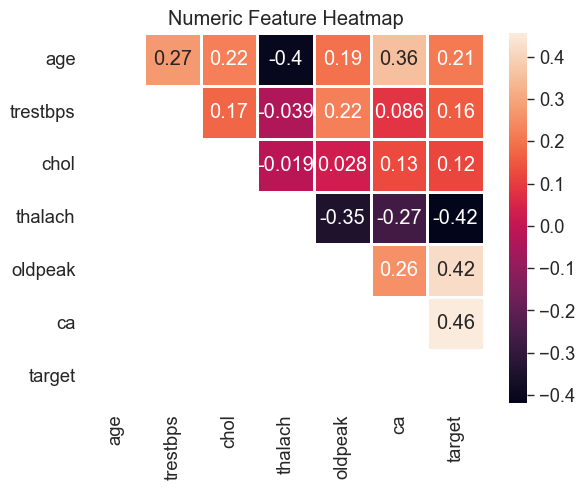

In [185]:
# considering ca ordered as only has 4 values
numericFeatures = ["age", "trestbps", "chol", "thalach", "oldpeak", "ca"]
categoricalFeatures = ["sex", "cp", "fbs", "restecg", "exang", "slope", "thal"]

X_numeric = X_oneHot[numericFeatures]
dataCorr = pd.concat([X_numeric, data["target"]], axis=1).corr()

upperHalf_mask = np.tril(np.ones_like(dataCorr, dtype=bool))

plt.figure()
plt.title("Numeric Feature Heatmap")
sns.heatmap(dataCorr, annot=True, linewidths=2, mask=upperHalf_mask)
plt.savefig(f"plots/numeric_heatmap.png")
plt.show()


From this we can choose to only include the 3 features that mostly correlate with the target: **thalach**, **oldpeak** and **ca**.

In [186]:
X_oneHot_heatmapped = data.drop(["age", "trestbps", "chol"], axis=1)

# print(X_oneHot_heatmapped.head())


## Principal Component Analysis

[PCA Explanation](https://builtin.com/data-science/step-step-explanation-principal-component-analysis)  

GitHub Copilot: Advantages of using PCA for dimensionality reduction:

1. **Removes Correlated Features**: In the real world, features are often correlated. PCA allows you to identify the most important features of your dataset, reducing it to a smaller set of uncorrelated features, known as principal components.

2. **Improves Algorithm Performance**: With fewer features, the performance of a machine learning algorithm can improve. It can also reduce overfitting.

3. **Reduces Overfitting**: By reducing the dimensionality of your feature space, you're less likely to overfit your model.

4. **Improves Visualization**: It's hard to visualize high dimensional data. PCA transforms a high dimensional data set to 2 or 3 dimensions so we can plot and understand data better.

Disadvantages of using PCA:

1. **Independent variables become less interpretable**: After implementing PCA, your original features will turn into Principal Components. Principal Components are the linear combination of your original features. Principal Components are not as readable and interpretable as original features.

2. **Data standardization is must before PCA**: You must standardize your data before implementing PCA, otherwise PCA will not be able to find the optimal Principal Components.

3. **Information Loss**: Although principal components attempt to retain as much information as possible, some information is lost when reducing dimensions, which can potentially degrade the performance of your machine learning model.

4. **Doesn't handle non-linear features well**: PCA assumes that the principal components are a linear combination of the original features. If this assumption is not true, PCA may not give you the results you're looking for.

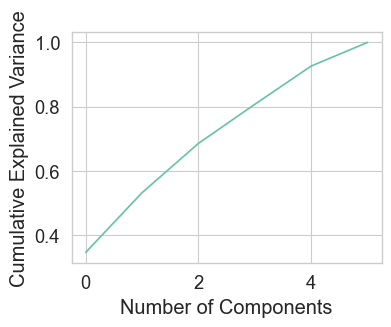

In [188]:
from sklearn.decomposition import PCA

pca = PCA(n_components=len(X_numeric.columns))
pca_result = pca.fit_transform(X_numeric)

explained_variance = pca.explained_variance_ratio_

# plot no of components vs cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(4, 3))
plt.plot(explained_variance, )
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()



By plotting the *Number of Components* against the *Cumulative Explained Variation*, we can see that 5 principal components are useful to explain 100% of the variance, the same number of numeric features. PCA won't provide the benefit of reducing dimensionality of the dataset.

Copilot:

That said, PCA can still be useful in this case for other reasons:

1. **Feature Independence**: The PCs are linearly independent of each other, which can help with certain types of models that assume feature independence (like linear regression).

2. **Interpretability**: PCs can sometimes be interpreted in terms of the original features, which can provide insights into the structure of your data.

3. **Noise Reduction**: PCA can help to reduce noise in your data by focusing on the directions of maximum variance and ignoring smaller, potentially noisy fluctuations.

In [208]:
from mpl_toolkits.mplot3d import Axes3D

nPCs = 5
pca = PCA(n_components=nPCs)
pca_result = pca.fit_transform(X)

explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance: {explained_variance}")
# print(pca.components_)  # feature weight for each pc

# Convert it back to a DataFrame
pca_df = pd.DataFrame(data=pca_result, columns=["PC" + str(i + 1) for i in range(nPCs)])


X_oneHot_PCAed = pd.concat([pca_df, X_oneHot.drop(X_numeric.columns, axis=1)], axis=1)

# print(X_oneHot_PCAed.columns)

Explained Variance: [0.35154221 0.14687296 0.09416467 0.08051433 0.07461979]


# Naive Bayes

In [222]:
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB


nb_results = cross_validate(GaussianNB(), X, Y, cv=5, scoring=["accuracy", "precision", "recall", "f1", "neg_log_loss"])
results_df = pd.DataFrame(nb_results)
print(results_df)

clf = GridSearchCV(GaussianNB(), {"var_smoothing": [1e-9, 1e-5, 1e-1]}, cv=5, scoring=["f1", "neg_log_loss"], return_train_score=False, refit=False)
clf.fit(X, Y)
results_gs = pd.DataFrame(clf.cv_results_)
results_gs[['param_var_smoothing', 'mean_test_f1', 'mean_test_neg_log_loss']]




   fit_time  score_time  test_accuracy  test_precision  test_recall   test_f1  \
0  0.001998    0.008001       0.814815        0.833333     0.833333  0.833333   
1  0.002998    0.007008       0.833333        0.838710     0.866667  0.852459   
2  0.001999    0.006998       0.888889        0.875000     0.933333  0.903226   
3  0.001998    0.005999       0.833333        0.838710     0.866667  0.852459   
4  0.002002    0.009030       0.833333        0.838710     0.866667  0.852459   

   test_neg_log_loss  
0          -0.778455  
1          -0.820856  
2          -0.333911  
3          -0.686468  
4          -0.527435  


,param_var_smoothing,mean_test_f1,mean_test_neg_log_loss
0,0.0,0.858787,-0.629425
1,0.00001,0.858787,-0.595637
2,0.1,0.731426,-0.595094


# Logistic Regression

In [229]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV


# nb_results = cross_validate(LogisticRegression(), standardizedX, Y, cv=5, scoring=["accuracy", "precision", "recall", "f1", "neg_log_loss"])
# results_df = pd.DataFrame(nb_results)
# print("standardizedX", "\n", results_df.mean(), "\n\n")


# nb_results = cross_validate(LogisticRegression(), normalizedX, Y, cv=5, scoring=["accuracy", "precision", "recall", "f1", "neg_log_loss"])
# results_df = pd.DataFrame(nb_results)
# print("normalizedX","\n", results_df.mean(), "\n\n")

# nb_results = cross_validate(LogisticRegression(), one_hot_standardizedX, Y, cv=5, scoring=["accuracy", "precision", "recall", "f1", "neg_log_loss"])
# results_df = pd.DataFrame(nb_results)
# print("one_hot_standardizedX","\n", results_df.mean(), "\n\n")

# nb_results = cross_validate(LogisticRegression(), one_hot_normalizedX, Y, cv=5, scoring=["accuracy", "precision", "recall", "f1", "neg_log_loss"])
# results_df = pd.DataFrame(nb_results)
# print("one_hot_normalizedX","\n", results_df.mean(), "\n\n")

param_grid = [    
    {
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

clf = GridSearchCV(LogisticRegression(), param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring=["f1", "neg_log_loss"], return_train_score=False, refit=False)
clf.fit(X, Y)
results_gs = pd.DataFrame(clf.cv_results_)
results_gs[['param_solver', 'param_max_iter', 'mean_test_f1', 'mean_test_neg_log_loss']]




Fitting 5 folds for each of 20 candidates, totalling 100 fits


,param_solver,param_max_iter,mean_test_f1,mean_test_neg_log_loss
0,lbfgs,100,0.866420,-0.407480
1,newton-cg,100,0.867823,-0.404644
2,liblinear,100,0.866314,-0.405866
3,sag,100,0.765340,-0.543240
4,saga,100,0.766901,-0.566636
5,lbfgs,1000,0.865091,-0.404979
6,newton-cg,1000,0.867823,-0.404644
7,liblinear,1000,0.866314,-0.405866
8,sag,1000,0.831881,-0.428492
9,saga,1000,0.802997,-0.457572


# KNN

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

clf = GridSearchCV(KNeighborsClassifier(), {"n_neighbors": [1, 3, 5, 7, 9]}, cv=5, scoring=["f1", "neg_log_loss"], return_train_score=False, refit=False)
clf.fit(one_hot_standardizedX, Y)
results_gs = pd.DataFrame(clf.cv_results_)
results_gs[['param_n_neighbors', 'mean_test_f1', 'mean_test_neg_log_loss']]


c:\Users\romeu\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\romeu\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

,param_n_neighbors,mean_test_f1,mean_test_neg_log_loss
0,1,0.796048,-7.931206
1,3,0.834426,-2.546506
2,5,0.843147,-1.694138
3,7,0.832644,-1.238183
4,9,0.823800,-0.881955
